## The Power Socket Problem

In [124]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')

### Stochastic Power Socket

In [125]:
class PowerSocket:
    def __init__(self, q):                
        self.q = q   # the true reward value                
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried
    
    # the reward is a random distribution around the initial mean value set for this socket
    # - never allow a charge less than 0 to be returned
    def charge(self):
        # a guassian distribution with unit variance around the true value 'q'
        value = np.random.randn() + self.q        
        return 0 if value < 0 else value
                    
    # increase the number of times this socket has been used and improve the estimate of the 
    # value (the mean) by combining the new reward 'r' with the current mean
    def update(self,R):
        self.n += 1

        # the new estimate is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

### Power Socket Testing

- create 5 sockets and examine what they return

In [126]:
# If FIXED_SOCKET_ORDER is set true then 5 sockets will be created with the same mean values as described in the Medium article.
# Otherwise, the specified number of sockets will be created with mean values that are assigned in a random order 
# (so the output of each socket can be different on each run).
FIXED_SOCKET_ORDER = True
NUM_SOCKETS = 5

# check that there are only 5 sockets if fixed socket ordering is being used
assert FIXED_SOCKET_ORDER == False or NUM_SOCKETS == 5, "When using a fixed socket order the number of sockets must be set to 5"

# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket 
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# create the order in which socket mean reward will be allocated
socket_order = []
if FIXED_SOCKET_ORDER:
    # create 5 sockets in a fixed order
    socket_order = [2,1,3,5,4]
else:
    # create the specified number of sockets in a random order 
    socket_order = random.sample(range(1,1+NUM_SOCKETS), NUM_SOCKETS)
    
print( f'Creating sockets with the order of increasing reward: {socket_order}')    

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):
    
    # get charge from the socket for the defined number of steps   
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()                

Creating sockets with the order of increasing reward: [2, 1, 3, 5, 4]


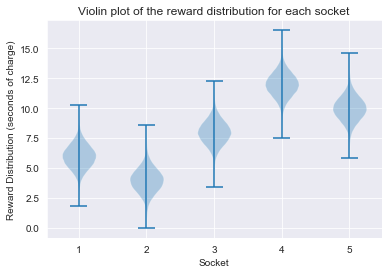

In [127]:
# plot the charge we got from the sockets           
plt.violinplot(rewards)   
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.title('Violin plot of the reward distribution for each socket')
plt.savefig('violin_plot.png')
plt.show() 

### Density Plots of the Socket Outputs

A density plot is a smoothed, continuous, version of a histogram estimated from the data.
The y-axis represents the probability density function of the socket.
The plot shows the relative outputs of each socket.
(see https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0 for more details on probability density functions)

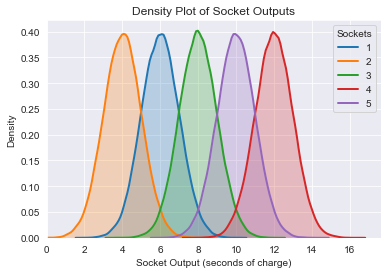

In [128]:
# iterate through the sockets to draw each plot
# (from: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');
    
# Plot formatting
plt.xlim(0, None)
plt.legend(title = 'Sockets')
plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')
plt.savefig("density_plot.png")

We could generate a similar plot just using histograms and splitting the output from each socket into a set of bins, where each bin would add up the number of outputs in that bin.

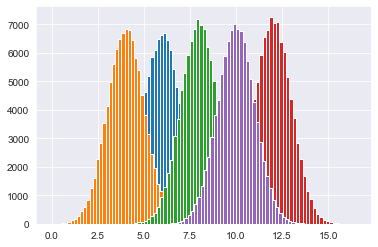

<Figure size 432x288 with 0 Axes>

In [129]:
for socket_number in range(NUM_SOCKETS):
    plt.hist(rewards[:,socket_number], bins=50)
plt.show()
plt.savefig('hist.png')

### Information about socket output values

Examine the current rewards from the sockets to find the maximum value

In [130]:
# test the maximum value from the sockets
np.amax(rewards)

16.505635526963136

In [131]:
# show the true values of each socket so we can display the maximum value
socket_means = [((q*2)+2) for q in socket_order]
socket_means

[6, 4, 8, 12, 10]




## Bandit Algorithms

### Optimistic-Greedy

In the Optimistic Greedy algorithm we want to set the initial estimates for each socket to a large value.


(NOTE: We'll reuse the sockets that have already been created, so their respective rewards should remain the same as the outputs shown above)

Initially set the estimate for each socket to a large value and initialize its count of the number of times the socket has been tried to 1 

In [132]:
# Create an Optimistic Power Socket class by inheriting from the standard Power Socket
class OptimisticPowerSocket( PowerSocket ):
    def __init__( self, q, initial_estimate = 0. ):    
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)        
        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = initial_estimate                 
        
        # the number of times this socket has been tried 
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if initial_estimate > 0 else 0          

In [133]:
# # make one socket

# initial_estimate = 5.

# # set to make a socket with highest reward
# q = 5

# socket = OptimisticPowerSocket((q*2)+2, initial_estimate)

# number_of_steps = 10

# print(f'true value = {socket.q} initial estimate = {socket.Q}')

# for t in range(number_of_steps):

#     # charge from the chosen socket and update its mean reward value
#     reward = socket.charge()
#     socket.update(reward)
    
#     print(f'step: {t} reward = {reward} estimate = {socket.Q}')

In [134]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [135]:
# number_of_steps = 10
# initial_estimate = 10.

# # create the optimistic sockets with the same order as the previous standard sockets
# sockets = [OptimisticPowerSocket((q*2)+2, initial_estimate) for q in socket_order] 

# # loop for the specified number of time-steps
# for t in range(number_of_steps):

#     # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie    
#     socket_index = random_argmax([socket.Q for socket in sockets])

#     # charge from the chosen socket and update its mean reward value
#     reward = sockets[socket_index].charge()
#     sockets[socket_index].update(reward)
    
#     print(f'step: {t} socket = {socket_index+1} reward = {reward} estimate = {sockets[socket_index].Q}')
#     for socket in sockets:
#         print(f'{socket.Q}', end = ',')
#     print('')

In [136]:
class SocketTester():

    def __init__(self, socket_order, initial_estimate = 0. ):  
        
        # create the optimistic sockets with a mean value defined by the socket order
        self.sockets = [OptimisticPowerSocket((q*2)+2, initial_estimate) for q in socket_order]                  
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)           

        # the index of the best socket is the last in the socket_order list
        # - this is a one-based value so convert to zero-based
        self.optimal_socket_index = (socket_order[-1] - 1)     
        
        # store any initial estimate used to initialize the sockets
        self.initial_estimate = initial_estimate
                     
       
    def run( self, number_of_steps ):            
        
        # save data about the run to create a table of estimates
        estimates = np.zeros(shape=(number_of_steps+1, self.number_of_sockets))

        # set the first estimates to be the initial value
        estimates[0] = self.initial_estimate 

        # monitor the total reward obtained over the run
        total_reward = 0

        # monitor the number of times the optimal socket was chosen
        optimal_socket_selected = 0

        # keep a count of the number of times each socket was selected
        selected_socket = np.zeros(shape=(self.number_of_sockets))   
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # select a socket
            socket_index = self.select_socket()

            # charge from the chosen socket and update its mean reward value
            reward = self.sockets[socket_index].charge()
            self.sockets[socket_index].update(reward)

            # store the estimates of each socket at this time step
            for socket_number in range(self.number_of_sockets):
                estimates[t+1,socket_number] = self.sockets[socket_number].Q 

            # update the total reward
            total_reward += reward

            # monitor the number of times the optimal socket was chosen
            if socket_index == self.optimal_socket_index: 
                optimal_socket_selected += 1      

            # increment the count of the number of times the selected socket has been used
            selected_socket[socket_index] += 1

        return estimates, (total_reward/number_of_steps), (optimal_socket_selected/number_of_steps), (selected_socket/number_of_steps)    
    
    
    def select_socket( self ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.Q for socket in self.sockets])  
        
        return socket_index

In [137]:
estimates, mean_reward, optimal_socket_percentage, socket_percentage = SocketTester( socket_order, initial_estimate = 20.).run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {mean_reward}')
print(f'Optimal Socket Selected = {optimal_socket_percentage}')
print(f'Socket Percentages = {socket_percentage}')


Mean Reward per Time Step = 11.171448292019425
Optimal Socket Selected = 0.7666666666666667
Socket Percentages = [0.03333333 0.03333333 0.06666667 0.76666667 0.1       ]


In [138]:
# def optimistic_greedy_test( number_of_steps, initial_estimate, number_of_sockets = NUM_SOCKETS ):
#     """ run an optimistic-greedy test 
#         return:
#         - the estimates of each socket's reward at each time step
#         - the mean reward per time step (= total reward / number of time steps)
#         - the percentage of the times the optimal socket was selected over the run
#     """
    
#     # create the optimistic sockets with the same order as the previous standard sockets
#     sockets = [OptimisticPowerSocket((q*2)+2, initial_estimate) for q in socket_order]    
    
#     # save data about the run to create a table of estimates
#     estimates = np.zeros(shape=(number_of_steps+1,number_of_sockets))

#     # set the first estimates to be the initial value
#     estimates[0] = initial_estimate 
    
#     # monitor the total reward obtained over the run
#     total_reward = 0
    
#     # monitor the number of times the optimal socket was chosen
#     optimal_socket_selected = 0
    
#     # the index of the best socket is the last in the socket_order list
#     # - this is a one-based value so convert to zero-based
#     optimal_socket_index = (socket_order[-1] - 1)
    
#     # keep a count of the number of times each socket was selected
#     selected_socket = np.zeros(shape=(number_of_sockets))

#     # loop for the specified number of time-steps
#     for t in range(number_of_steps):

#         # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie    
#         socket_index = random_argmax([socket.Q for socket in sockets])

#         # charge from the chosen socket and update its mean reward value
#         reward = sockets[socket_index].charge()
#         sockets[socket_index].update(reward)

#         # store the estimates of each socket at this time step
#         for socket_number in range(number_of_sockets):
#             estimates[t+1,socket_number] = sockets[socket_number].Q 
            
#         # update the total reward
#         total_reward += reward
        
#         # monitor the number of times the optimal socket was chosen
#         if socket_index == optimal_socket_index: 
#             optimal_socket_selected += 1      
        
#         # increment the count of the number of times the selected socket has been used
#         selected_socket[socket_index] += 1

#     return estimates, (total_reward/number_of_steps), (optimal_socket_selected/number_of_steps), (selected_socket/number_of_steps)

### Optimistic-Greedy Experiment 1
- setting the initial value based on the known maximum value of the sockets

In [139]:
# the maximum charge is around 16 seconds worth (for 5 sockets), therefore setting our initial estimates to 20 should be large enough
# estimates, mean_reward, optimal_socket_percentage, socket_percentage = optimistic_greedy_test( number_of_steps = 30, initial_estimate = 20. )
estimates, mean_reward, optimal_socket_percentage, socket_percentage = SocketTester( socket_order, initial_estimate = 20.).run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {mean_reward}')
print(f'Optimal Socket Selected = {optimal_socket_percentage}')
print(f'Socket Percentages = {socket_percentage}')

Mean Reward per Time Step = 10.921579209219523
Optimal Socket Selected = 0.7
Socket Percentages = [0.06666667 0.03333333 0.06666667 0.7        0.13333333]


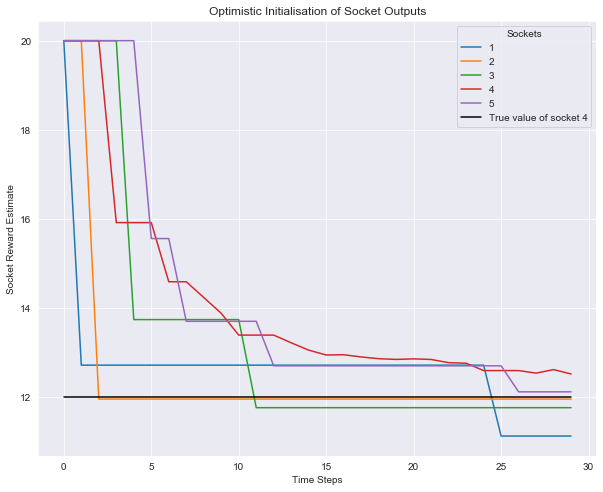

In [140]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')       

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

plt.savefig("optimistic_initialisation.png")

In [141]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()            
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):   
    '''
    highlight the entry before the column value changes
    '''    
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')    
    return style

In [142]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
df = pd.DataFrame(estimates)
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20,20,20,20,20
1,12.7089,20,20,20,20
2,12.7089,11.9469,20,20,20
3,12.7089,11.9469,20,15.9117,20
4,12.7089,11.9469,13.7327,15.9117,20
5,12.7089,11.9469,13.7327,15.9117,15.5536
6,12.7089,11.9469,13.7327,14.5827,15.5536
7,12.7089,11.9469,13.7327,14.5827,13.6943
8,12.7089,11.9469,13.7327,14.2298,13.6943
9,12.7089,11.9469,13.7327,13.8732,13.6943


## Optimistic-Greedy With Different Initialisation Values

In [143]:
def show_plot( socket_estimates ):
    plt.figure(figsize=(10,8))

    for socket in range(socket_estimates.shape[1]):
        plt.plot(socket_estimates[:,socket], label = f'{socket+1}')           

    plt.plot(np.ones(mean_estimates.shape[0])*np.max(socket_means),'k', label = f'True value of socket 4')

    plt.legend(title = 'Sockets')
    plt.title('Optimistic Initialisation of Socket Outputs')
    plt.xlabel('Time Steps')
    plt.ylabel('Socket Reward Estimate')

    plt.savefig("optimistic_initialisation_20.png")

In [144]:
def run_socket_experiment( number_of_tests, number_of_steps, initial_estimate, number_of_sockets = NUM_SOCKETS ):    
    
    # save data about the run to create a table of estimates
    mean_estimates = np.zeros(shape=(number_of_steps+1,number_of_sockets))    
    
    mean_reward_per_timestep = 0.
    mean_optimal_selected = 0.
    
    mean_socket_percentage = np.zeros(number_of_sockets)
    
    for n in tqdm(range(1,number_of_tests+1)):
        
        # do one run of the test        
#         estimates, reward_per_timestep, optimal_socket_percentage, socket_percentage = optimistic_greedy_test( number_of_steps, initial_estimate )
        estimates, reward_per_timestep, optimal_socket_percentage, socket_percentage = SocketTester( socket_order, initial_estimate ).run( number_of_steps )
        
        # the new estimate is calculated from the old estimate
        mean_estimates = (1 - 1.0/n) * mean_estimates + (1.0/n) * estimates        
        
        # calculate the new means from the old means and the new value
        mean_reward_per_timestep = (1 - 1.0/n) * mean_reward_per_timestep + (1.0/n) * reward_per_timestep
        mean_optimal_selected = (1 - 1.0/n) * mean_optimal_selected + (1.0/n) * optimal_socket_percentage
        
        mean_socket_percentage = (1 - 1.0/n) * mean_socket_percentage + (1.0/n) * socket_percentage
    
    return mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage

100%|██████████| 1000/1000 [00:02<00:00, 489.60it/s]


Mean Reward per Time Step= 10.993806442816938
Optimal Socket Selected = 0.7552749999999998
Mean Socket Percentages = [0.04845  0.033925 0.058575 0.755275 0.103775]


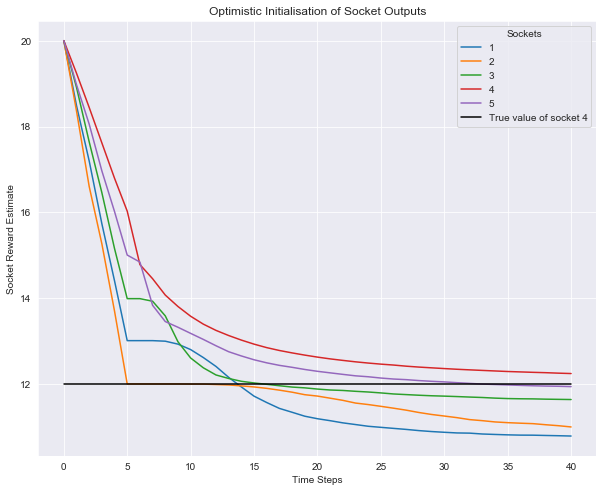

In [145]:
# 1. Initialisation = 20  
mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = run_socket_experiment( number_of_tests = 1000, number_of_steps = 40, initial_estimate = 20. )   

print(f'Mean Reward per Time Step= {mean_reward_per_timestep}')
print(f'Optimal Socket Selected = {mean_optimal_selected}')
print(f'Mean Socket Percentages = {mean_socket_percentage}')

show_plot( mean_estimates )    

### 1. An initial value less than the maximum value

100%|██████████| 1000/1000 [00:01<00:00, 505.42it/s]


Mean Reward per Time Step= 9.21886335856271
Optimal Socket Selected = 0.28249999999999914
Mean Socket Percentages = [0.205775 0.0064   0.242725 0.2825   0.2626  ]


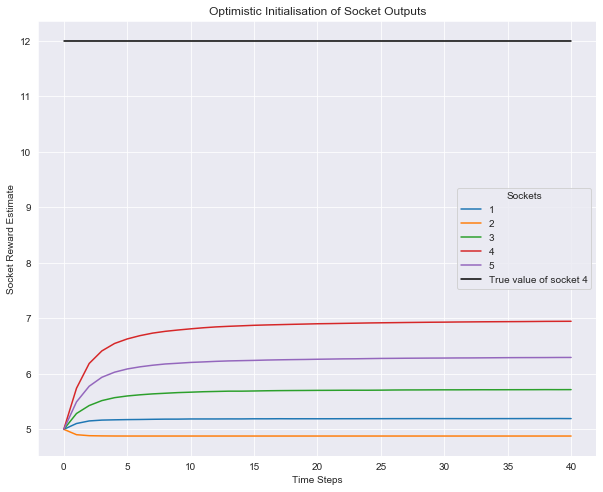

In [146]:
# 2. Initialisation = 5  
mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = run_socket_experiment( number_of_tests = 1000, number_of_steps = 40, initial_estimate = 5. )   

print(f'Mean Reward per Time Step= {mean_reward_per_timestep}')
print(f'Optimal Socket Selected = {mean_optimal_selected}')
print(f'Mean Socket Percentages = {mean_socket_percentage}')

# NOTE - this graph is misleading, since the estimate from the optimal socket #4
# is never a value approximately 7
# - it is either its true value (when it has been selected as the greedy action)
# or it stays at 5, its initialisation value, when not selected
show_plot( mean_estimates )  

### 2. An initial value much larger than the maxium value

100%|██████████| 1000/1000 [00:02<00:00, 490.47it/s]


Mean Reward per Time Step= 7.991377988636653
Optimal Socket Selected = 0.20000000000000026
Mean Socket Percentages = [0.2 0.2 0.2 0.2 0.2]


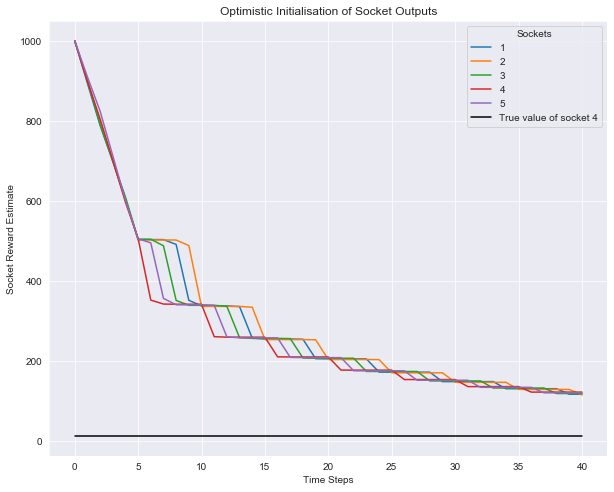

In [147]:
# 2. Initialisation = 1000
mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = run_socket_experiment( number_of_tests = 1000, number_of_steps = 40, initial_estimate = 1000. )   

print(f'Mean Reward per Time Step= {mean_reward_per_timestep}')
print(f'Optimal Socket Selected = {mean_optimal_selected}')
print(f'Mean Socket Percentages = {mean_socket_percentage}')

show_plot( mean_estimates ) 

In [148]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)

    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r') 

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')

    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')

    plt.savefig(f"mean_total_reward_v_initial_values_{max_initial_value}.png")

In [149]:
def run_initialisation_experiment( start, end, step = 1 ):     
    
    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = NUM_SOCKETS    
    
    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []
        
    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):
        
        initial_values.append( initial_estimate )
        
        mean_reward_per_timestep = 0.
        mean_optimal_selected = 0.        
        
        mean_socket_percentage = np.zeros(number_of_sockets)
    
        # do the specified number of runs for a single test
        for n in range(1,number_of_tests+1):

            # do one run of the test        
            estimates, reward_per_timestep, optimal_socket_percentage, socket_percentage = SocketTester( socket_order, initial_estimate ).run( number_of_steps )
        
            # calculate the new means from the old means and the new value
            mean_reward_per_timestep = (1 - 1.0/n) * mean_reward_per_timestep + (1.0/n) * reward_per_timestep
            mean_optimal_selected = (1 - 1.0/n) * mean_optimal_selected + (1.0/n) * optimal_socket_percentage
            mean_socket_percentage = (1 - 1.0/n) * mean_socket_percentage + (1.0/n) * socket_percentage                              
                
        reward.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage )
     
    return initial_values, reward, optimal_selected, socket_percentages                      

100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


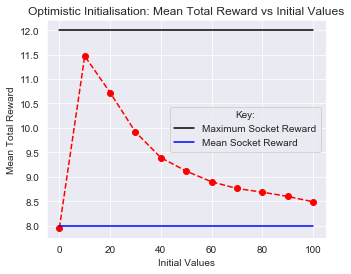

In [150]:
max_initial_value = 100   
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )

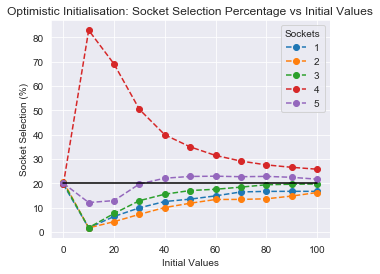

In [151]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')

plt.savefig("optimistic_initialisation_percentages.png")


100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


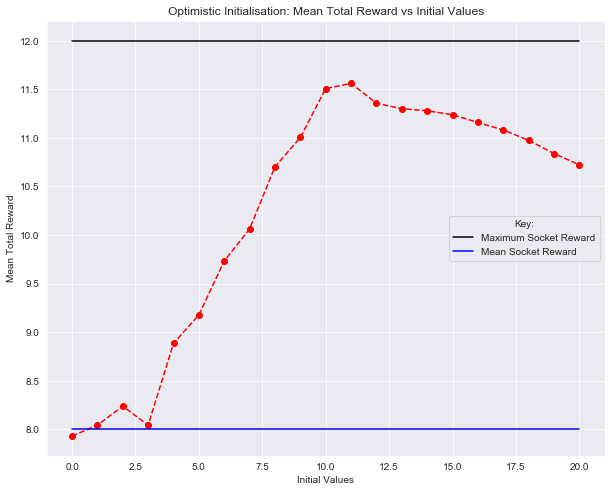

In [152]:
max_initial_value = 20   
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value )

In [153]:
# the maximum charge is around 16 seconds worth (for 5 sockets), therefore setting our initial estimates to 20 should be large enough
# estimates, mean_reward, optimal_socket_percentage,_ = optimistic_greedy_test( number_of_steps = 30, initial_estimate = 11. )
estimates, mean_reward, optimal_socket_percentage, socket_percentage = SocketTester( socket_order, initial_estimate = 11. ).run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {mean_reward}')
print(f'Optimal Socket Selected = {optimal_socket_percentage}')

Mean Reward per Time Step = 11.352071714175768
Optimal Socket Selected = 0.8666666666666667


# Epsilon-Greedy

In [154]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, socket_order, epsilon = 0. ):  
        
        # create a standard socket tester
        super().__init__(socket_order) 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_socket( self ):
        """ Epsilon-Greedy Socket Selection"""
        
        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
            socket_index = random_argmax([socket.Q for socket in self.sockets])               
        
        return socket_index

In [155]:
estimates, mean_reward, optimal_socket_percentage, socket_percentage = EpsilonGreedySocketTester( socket_order, epsilon = 0.1 ).run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {mean_reward}')
print(f'Optimal Socket Selected = {optimal_socket_percentage}')
print(f'Socket Percentages = {socket_percentage}')

Mean Reward per Time Step = 11.628493206030875
Optimal Socket Selected = 0.919
Socket Percentages = [0.019 0.02  0.018 0.919 0.024]


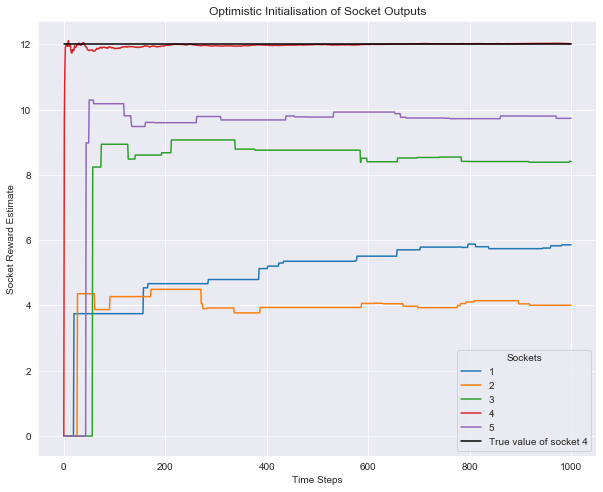

In [156]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:,socket], label = f'{socket+1}')       

plt.plot(np.ones(estimates.shape[0])*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

plt.savefig("optimistic_initialisation.png")

In [179]:
def epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon = 0., number_of_sockets = NUM_SOCKETS, hide_progress = False ):    
    
    # save data about the run 
    mean_estimates = np.zeros(shape=(number_of_steps+1,number_of_sockets))        
    mean_reward_per_timestep = 0.
    mean_optimal_selected = 0.    
    mean_socket_percentage = np.zeros(number_of_sockets)
    
    # do the specified number of runs for a single test    
    for n in tqdm(range(1,number_of_tests+1),disable=hide_progress):
#     for n in range(1,number_of_tests+1):        
        
        # do one run of the test        
        tester = EpsilonGreedySocketTester( socket_order, epsilon )
        estimates, reward_per_timestep, optimal_socket_percentage, socket_percentage = tester.run( number_of_steps )
        
        # the new estimate is calculated from the old estimate
        mean_estimates = (1 - 1.0/n) * mean_estimates + (1.0/n) * estimates        
        
        # calculate the new means from the old means and the new value
        mean_reward_per_timestep = (1 - 1.0/n) * mean_reward_per_timestep + (1.0/n) * reward_per_timestep
        mean_optimal_selected = (1 - 1.0/n) * mean_optimal_selected + (1.0/n) * optimal_socket_percentage        
        mean_socket_percentage = (1 - 1.0/n) * mean_socket_percentage + (1.0/n) * socket_percentage
    
    return mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage

100%|██████████| 1000/1000 [00:13<00:00, 74.09it/s]


Mean Reward per Time Step= 11.198097298062175
Optimal Socket Selected = 0.7954699999999998
Mean Socket Percentages = [0.03302667 0.02702667 0.04684    0.79547    0.09763667]


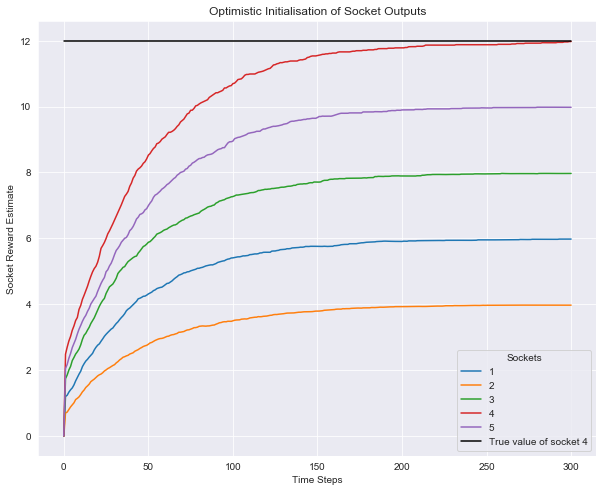

In [186]:
mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests = 1000, number_of_steps = 300, epsilon = 0.1 )   

print(f'Mean Reward per Time Step= {mean_reward_per_timestep}')
print(f'Optimal Socket Selected = {mean_optimal_selected}')
print(f'Mean Socket Percentages = {mean_socket_percentage}')

show_plot( mean_estimates )    

In [189]:
def run_epsilon_greedy_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):     
    
    number_of_sockets = NUM_SOCKETS    
    
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    test_values = []
    final_socket_estimates = []
        
    # iterate over the epsilon values
    for epsilon in tqdm( np.arange( start, (end+step), step ) ):
        
        # save the test value used to run this test
        test_values.append( epsilon )
        
        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon, hide_progress = True )                           
                
        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage ) 
        final_socket_estimates.append( mean_estimates[-1] )
     
    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates                    

In [238]:
def plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

    plt.plot(epsilon_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Socket Selection (%)')
     
def plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps ):    
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')           

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Final Socket Estimate')    
    
def plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):
    
    plt.plot( epsilon_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
    plt.title('Mean Total Reward per Time Step vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Total Reward per Time Step')  
    
    
def plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Epsilon Greedy: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps )

    plt.savefig(f"epsilon_greedy_{number_of_steps}.png")

    plt.show()    

In [206]:
# how many times each test should be run
number_of_tests = 500

# the epsilon test range
start = 0
stop = 1.0
step = 0.05

In [234]:
steps = 100
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, steps )  

100%|██████████| 21/21 [00:38<00:00,  1.81s/it]


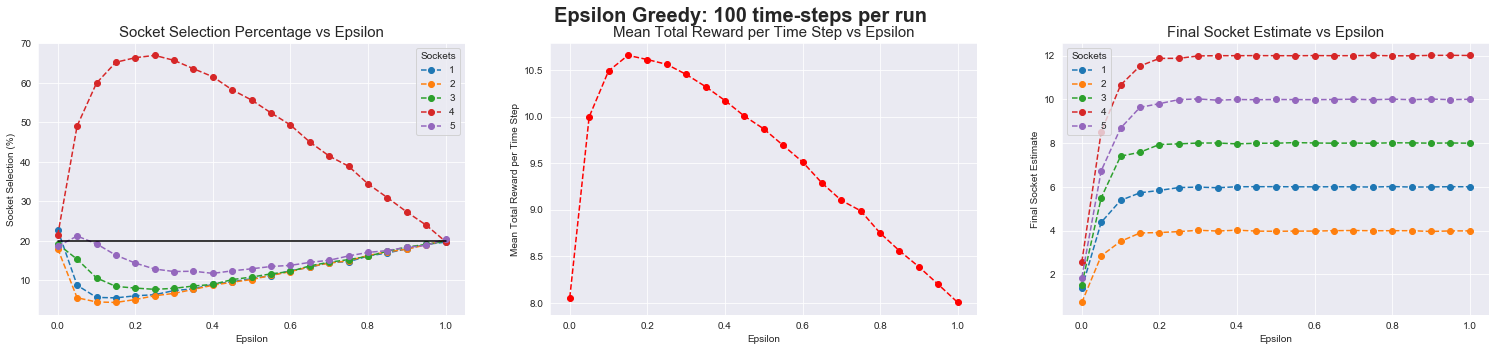

In [239]:
plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, steps ) 

100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


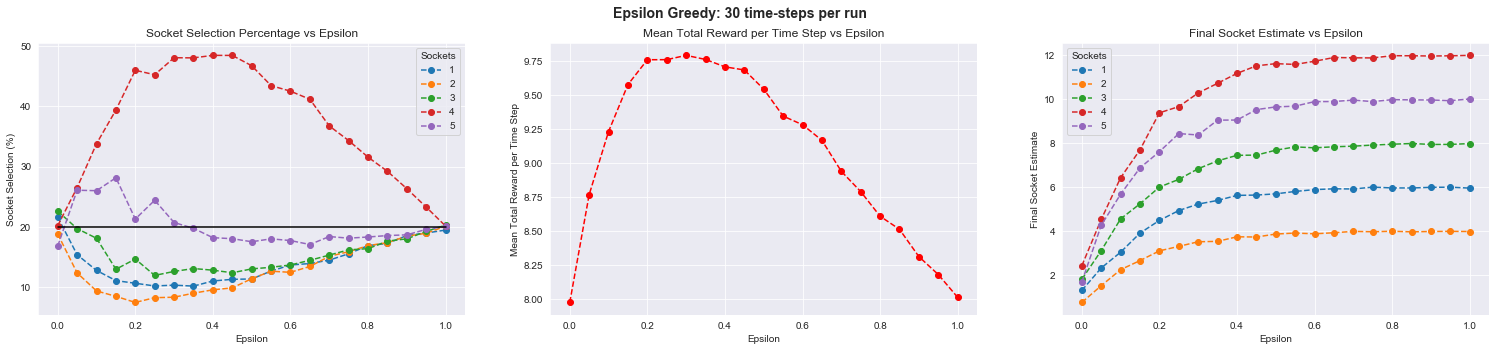

100%|██████████| 21/21 [00:38<00:00,  1.84s/it]


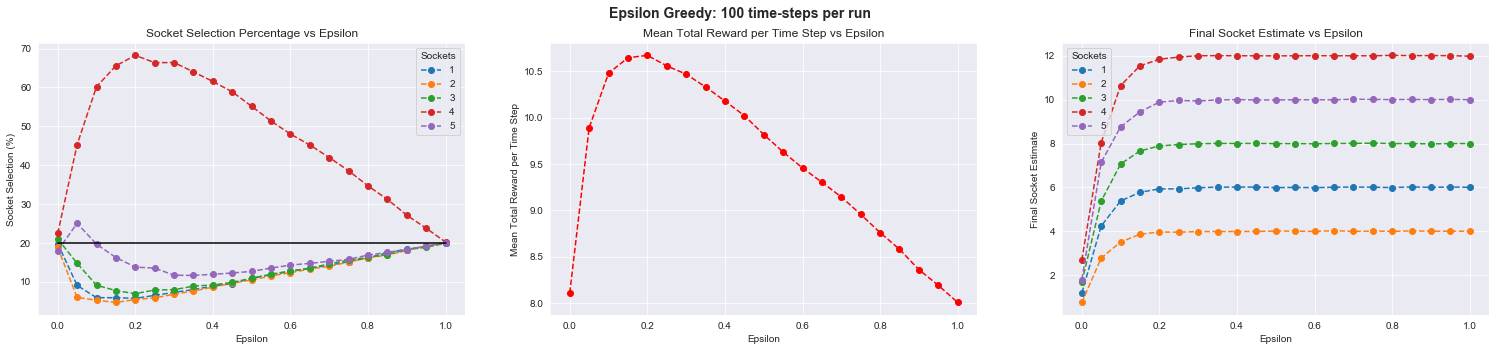

100%|██████████| 21/21 [01:16<00:00,  3.62s/it]


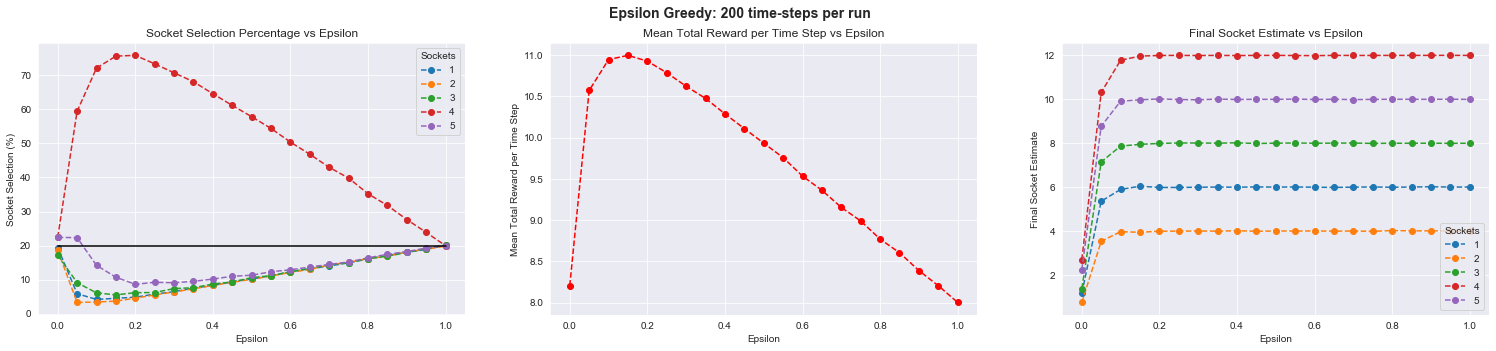

100%|██████████| 21/21 [03:08<00:00,  8.97s/it]


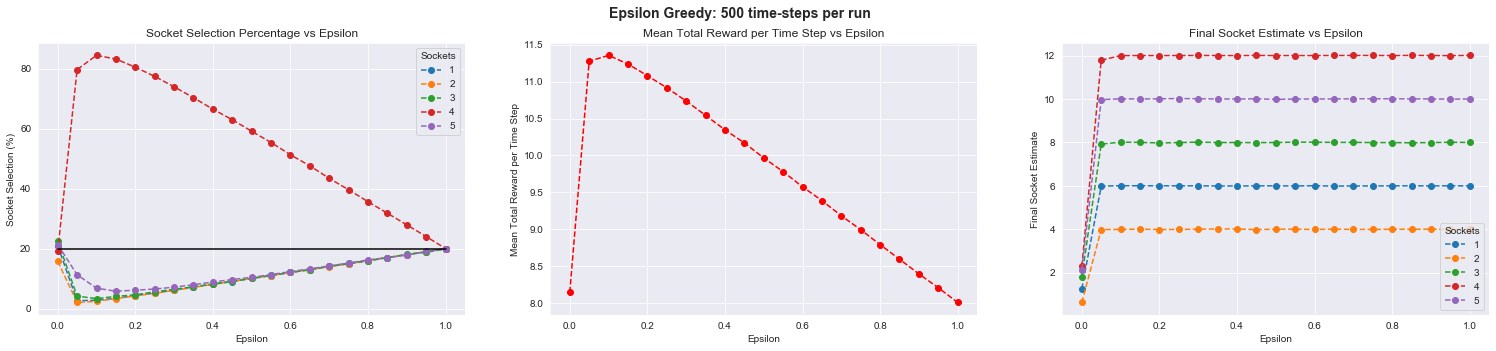

In [223]:
# number_of_steps = [30,100,200,500]
# for steps in number_of_steps:

#     epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, steps )  
#     plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, steps ) 

In [215]:
number_of_steps = 30
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )  

100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


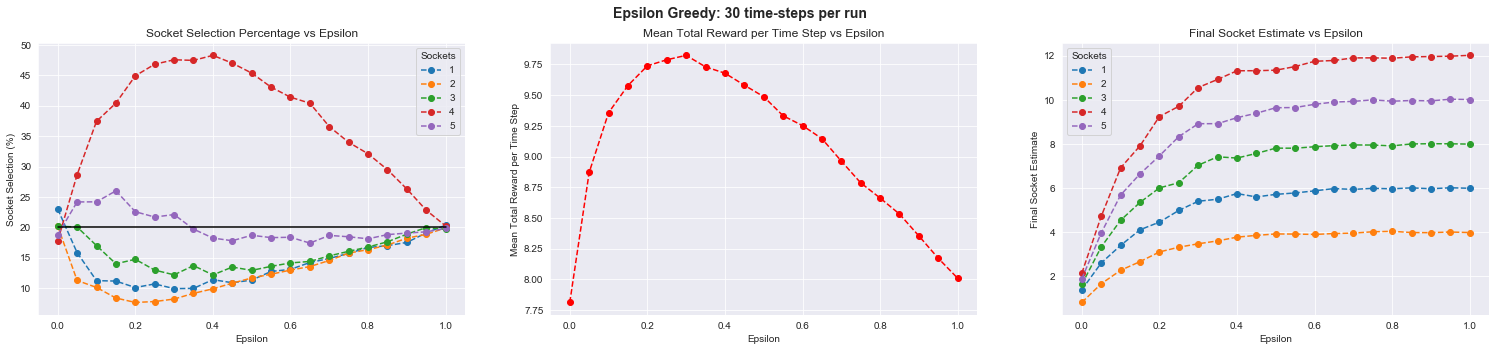

In [216]:
plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps )

100%|██████████| 21/21 [00:38<00:00,  1.83s/it]


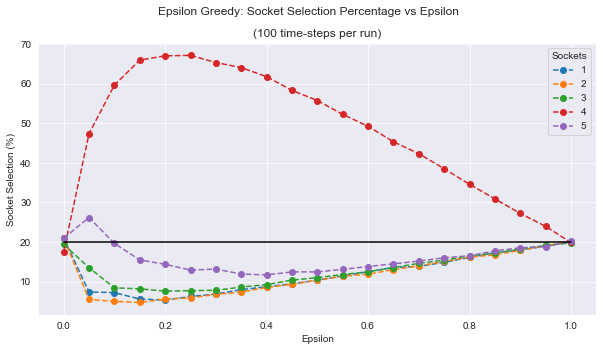

In [64]:
number_of_steps = 100
epsilon_values, reward, optimal_selected, socket_percentages = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )  
plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

100%|██████████| 21/21 [01:15<00:00,  3.60s/it]


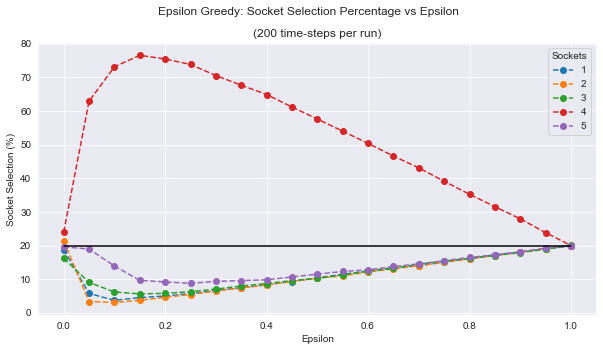

In [65]:
number_of_steps = 200
epsilon_values, reward, optimal_selected, socket_percentages = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )  
plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

100%|██████████| 21/21 [03:08<00:00,  8.98s/it]


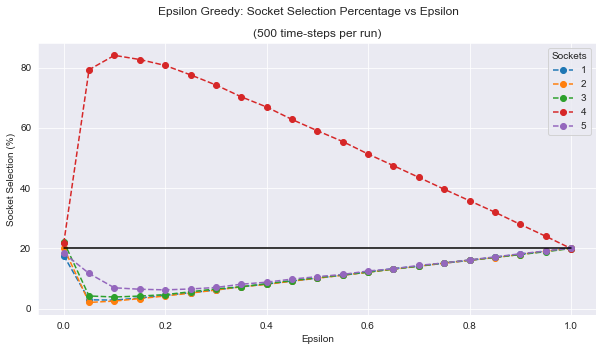

In [66]:
number_of_steps = 500
epsilon_values, reward, optimal_selected, socket_percentages = run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )  
plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )